# Long short-term memory Forecasting

## Inhalt

1. **Datenexploration und Vorverarbeitung**: Zuerst wird ein Pandas DataFrame mit historischen Aktienkursdaten erstellt. Die Daten werden so gefiltert, dass nur die Daten des letzten Monats betrachtet werden und bestimmte Spalten (Close, High, Low, Open) für die Analyse ausgewählt werden.

2. **Datenvisualisierung**: Die ausgewählten Spalten werden in einem Lineplot visualisiert, um Trends und Muster in den Daten zu identifizieren.

3. **Daten vorbereitung für das Modelltraining**: Die Daten werden auf einen Bereich zwischen 0 und 1 skaliert. Dies ist ein üblicher Schritt bei der Verwendung von Neuronalen Netzwerken, um sicherzustellen, dass alle Eingaben in einem ähnlichen Bereich liegen. Danach werden die Daten in Trainings- und Testdatensätze aufgeteilt und in die für ein LSTM (Long Short-Term Memory) Modell erforderliche Form gebracht.

4. **Modell Erstellung und Training**: Ein LSTM Modell wird mit Keras erstellt und auf den Trainingsdaten trainiert.

5. **Modell Evaluierung**: Der Trainingsverlauf des Modells wird visualisiert und die Vorhersagen des Modells auf den Testdaten werden mit den tatsächlichen Werten verglichen.

6. **Vorhersage der zukünftigen Aktienkurse**: Das trainierte Modell wird verwendet, um Vorhersagen für die nächsten 30 Tage zu treffen, die dann in den DataFrame eingefügt werden.

7. **Datenspeicherung in der Datenbank**: Die neuen Vorhersagen werden in eine bestehende SQL Server-Datenbank geschrieben. Hierbei wird darauf geachtet, Duplikate zu vermeiden und nur neue Vorhersagen hinzuzufügen, die noch nicht in der Datenbank vorhanden sind.

Es werden verschiedene Bibliotheken und Pakete importiert, die für die Datenanalyse und den Aufbau eines Deep-Learning-Modells erforderlich sind

---

In diesem Code wird eine Reihe von Python-Bibliotheken importiert, die für das Training eines LSTM-Neuronale-Netzwerk-Modells (Long Short-Term Memory) nützlich sind. Dies sind die Hauptkomponenten und deren Funktionen:

1. **math, numpy und pandas**: Diese Bibliotheken werden für mathematische Berechnungen und Datenmanipulationen verwendet. Sie ermöglichen das Arbeiten mit Daten in einer strukturierten Weise.

2. **datetime**: Diese Bibliothek wird für die Arbeit mit Daten und Zeitstempeln verwendet.

3. **pandas.plotting.register_matplotlib_converters, matplotlib und seaborn**: Dies sind Visualisierungsbibliotheken, die zum Plotten und Anzeigen von Daten und Analyseergebnissen verwendet werden.

4. **tensorflow und tensorflow.keras**: Tensorflow ist eine weit verbreitete Bibliothek für das maschinelle Lernen und wird hier verwendet, um ein LSTM-Modell zu erstellen und zu trainieren. Keras ist eine High-Level-API von Tensorflow, die das Erstellen und Trainieren von Modellen erleichtert. LSTM, Dense und Dropout sind Schichten, die in einem Neuronalen Netzwerk verwendet werden, und EarlyStopping ist eine Technik, um das Training zu stoppen, wenn das Modell nicht mehr besser wird.

5. **sklearn.metrics**: Diese Bibliothek enthält Funktionen zur Bewertung der Modellperformance. Die Funktionen mean_absolute_error und mean_squared_error werden verwendet, um den Fehler des Modells zu berechnen.

6. **sklearn.preprocessing**: RobustScaler und MinMaxScaler sind Techniken zur Datennormalisierung, die oft in maschinellen Lernmodellen verwendet werden, um die Performance zu verbessern.

Am Ende des Codes überprüft der Anwender die Tensorflow-Version und die verfügbaren physischen Geräte (in diesem Fall CPU).

Das ist im Grunde eine Vorbereitungsphase, in der alle notwendigen Werkzeuge importiert werden. Es ist sehr wahrscheinlich, dass nach diesem Abschnitt der Datenimport, die Vorverarbeitung und schließlich das Training des LSTM-Modells folgen werden.

In [22]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('CPU')

Tensorflow Version: 2.10.0


Zunächst wird eine Verbindung zu einer SQL Server-Datenbank hergestellt und es werden Aktiendaten für ein spezifisches Unternehmen extrahiert. Die relevanten Daten werden in einem Dataframe gespeichert. Zur weiteren Bearbeitung wird eine Transformation der Daten angewandt.

In [2]:
import pyodbc
import yfinance as yf
import pandas as pd
from sqlalchemy import create_engine
import datetime
from datetime import date, timedelta

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Tabelle prüfen
table_name = "stock_data"  # Name der Zieltabelle
start_date = "2020-07-01"  # Startdatum, ab dem Daten überprüft werden sollen
end_date = "2023-06-01"  # Enddatum, bis zu dem Daten überprüft werden sollen
company_name = "GOOG"  # nur AAPL, MSFT oder GOOG möglich // Name des Unternehmens, für das Daten geladen werden sollen

# Daten aus der Tabelle für das bestimmte Unternehmen in einen DataFrame laden
select_query = f"SELECT * FROM {table_name} WHERE date >= ? AND date <= ? AND Company = ?"
data = pd.read_sql(select_query, con=engine, params=(start_date, end_date, company_name))

# added
data["ID"] = data.index
data = data[["Date", "Company", "Type", "Open", "High", "Low", "Close", "Volume"]]
data.reset_index(drop=True, inplace=True)

# Verbindung schließen
cnxn.close()

# DataFrame anzeigen
print(data.tail())


          Date Company Type        Open        High         Low       Close  \
730 2023-05-25    GOOG  ACT  125.209999  125.980003  122.900002  124.349998   
731 2023-05-26    GOOG  ACT  124.065002  126.000000  123.290001  125.430000   
732 2023-05-30    GOOG  ACT  126.290001  126.379997  122.889999  124.639999   
733 2023-05-31    GOOG  ACT  123.699997  124.900002  123.099998  123.370003   
734 2023-06-01    GOOG  ACT  123.500000  125.040001  123.300003  124.370003   

       Volume  
730  33812700  
731  25154700  
732  27230700  
733  41548800  
734  25017700  


Diese Schritte dienen dazu, bestimmte Spalten aus dem DataFrame zu entfernen und die Indexierung auf das Datum festzulegen. Dadurch wird der DataFrame besser für weitere Analyse- und Visualisierungszwecke geeignet.

In [4]:
df = data #Unterscheidung zu Arima
df.drop("Company", axis=1, inplace=True)
df.drop("Type", axis=1, inplace=True)
df.set_index("Date", inplace=True)

In [5]:
df


,Open,High,Low,Close,Volume
Date,,,,,
2020-07-01,70.555000,72.150002,70.490997,71.902000,35504000
2020-07-02,72.347000,74.147499,72.320999,73.235001,37182000
2020-07-06,74.002998,75.329498,73.642998,74.785004,31280000
2020-07-07,74.500000,75.839996,74.177498,74.259003,29164000
2020-07-08,74.716003,75.293999,74.281502,74.800003,24994000
...,...,...,...,...,...
2023-05-25,125.209999,125.980003,122.900002,124.349998,33812700
2023-05-26,124.065002,126.000000,123.290001,125.430000,25154700
2023-05-30,126.290001,126.379997,122.889999,124.639999,27230700


Es folgt die Erstellung eines Liniendiagramms, das die Verläufe der Spalten "Close", "High", "Low" und "Open" visualisiert.

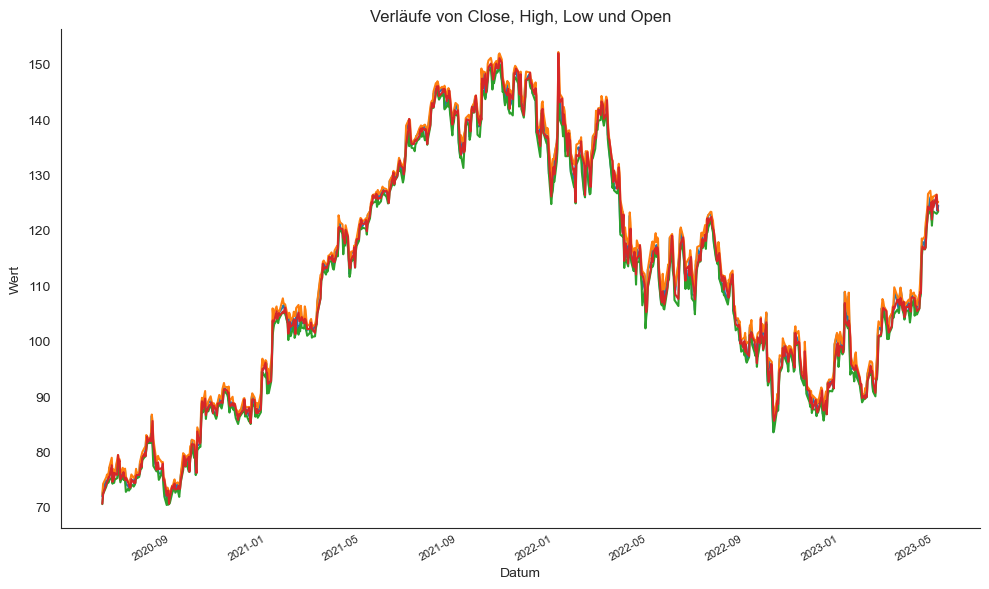

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Annahme: df ist der DataFrame, der die Daten enthält

# Auswahl der gewünschten Spalten
df_plot = df[['Close', 'High', 'Low', 'Open']].copy()

# Plot Line Chart
fig, ax = plt.subplots(figsize=(10, 6))
for column in df_plot.columns:
    sns.lineplot(data=df_plot[column], ax=ax)

ax.set_xlabel('Datum')
ax.set_ylabel('Wert')
ax.set_title('Verläufe von Close, High, Low und Open')

ax.tick_params(axis="x", rotation=30, labelsize=8, length=0)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.show()


Zur besseren Veranschaulichung wird ein weiteres Liniendiagramm erzeugt, das die Verläufe der Spalten "Close", "High", "Low" und "Open" für den letzten Monat visualisiert. Dabei werden unterschiedliche Farben, Linienstärken und Linienstile verwendet, um die einzelnen Linien im Diagramm zu unterscheiden.

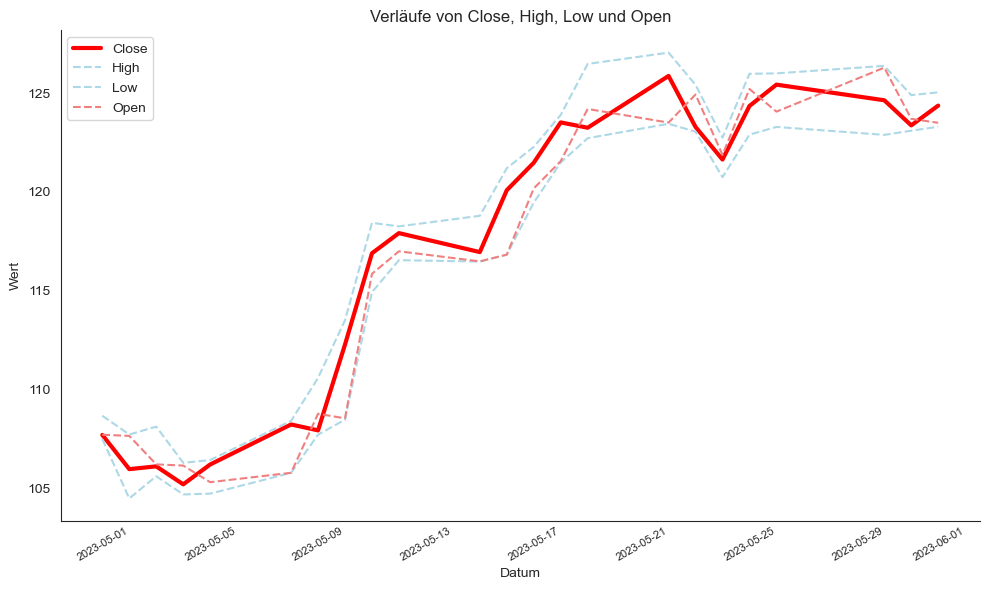

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Annahme: df ist der DataFrame, der die Daten enthält

# Filtern des DataFrame auf den letzten Monat
df_last_month = df.loc[df.index >= df.index.max() - pd.DateOffset(months=1)]

# Auswahl der gewünschten Spalten
df_plot = df_last_month[['Close', 'High', 'Low', 'Open']].copy()

# Plot Line Chart
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df_plot['Close'], ax=ax, color='red', linewidth=3, label='Close')
sns.lineplot(data=df_plot['High'], ax=ax, color='lightblue', linewidth=1.5, linestyle='dashed', label='High')
sns.lineplot(data=df_plot['Low'], ax=ax, color='lightblue', linewidth=1.5, linestyle='dashed', label='Low')
sns.lineplot(data=df_plot['Open'], ax=ax, color='lightcoral', linewidth=1.5, linestyle='dashed', label='Open')

ax.set_xlabel('Datum')
ax.set_ylabel('Wert')
ax.set_title('Verläufe von Close, High, Low und Open')

ax.tick_params(axis="x", rotation=30, labelsize=8, length=0)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.legend()
plt.show()


Im nächsten Schritt erfolgt die Datenmanipulationen und Vorbereitungen für das Training eines Modells durchgeführt.

- Es wird eine Liste von betrachteten Features (`FEATURES`) definiert. Diese Liste enthält die ausgewählten Spaltennamen, die für das Training des Modells verwendet werden sollen. In diesem Fall sind es 'High', 'Low', 'Open', 'Close' und 'Volume'.

In [8]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume']

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2023-05-25,125.980003,122.900002,125.209999,124.349998,33812700,124.349998
2023-05-26,126.000000,123.290001,124.065002,125.430000,25154700,125.430000
2023-05-30,126.379997,122.889999,126.290001,124.639999,27230700,124.639999
2023-05-31,124.900002,123.099998,123.699997,123.370003,41548800,123.370003
2023-06-01,125.040001,123.300003,123.500000,124.370003,25017700,124.370003


Im weiteren Teil des Codes werden die Daten skaliert, um sie auf einen Wertebereich zwischen 0 und 1 zu bringen. Hier ist eine Beschreibung:

- Die Anzahl der Zeilen im DataFrame `data_filtered` wird mit `nrows = data_filtered.shape[0]` ermittelt.

- Mit `np_data_unscaled = np.array(data_filtered)` wird `np_data_unscaled` erstellt, eine numpy-Array-Repräsentation der ungeklärten Daten. Der Datenarray wird mit `np.reshape()` in das gewünschte Format umgeformt, wobei die Anzahl der Zeilen (`nrows`) beibehalten wird und die Anzahl der Spalten automatisch angepasst wird.

- Die Daten werden mit Hilfe des `MinMaxScaler` auf einen Wertebereich zwischen 0 und 1 skaliert. Zuerst wird ein Scaler-Objekt `scaler` erstellt. Dann wird `np_data_unscaled` mit `scaler.fit_transform(np_data_unscaled)` transformiert und in `np_data_scaled` gespeichert.

- Es wird ein separater Scaler `scaler_pred` erstellt, der nur auf eine einzelne Spalte (`'Close'`) angewendet wird. Dafür wird eine separate DataFrame `df_Close` erstellt, die nur die Spalte `'Close'` aus `data_filtered_ext` enthält. Mit `scaler_pred.fit_transform(df_Close)` wird die Skalierung auf die Daten der Spalte `'Close'` angewendet und in `np_Close_scaled` gespeichert.

- Die Skalierung ermöglicht es, die Daten auf einen einheitlichen Wertebereich zu bringen, was bei der Verwendung von bestimmten Modellen und Algorithmen von Vorteil sein kann.

Der Schritt bereitet die Daten vor, indem er sie skaliert, um sicherzustellen, dass alle Features auf den gleichen Wertebereich gebracht werden. Dabei wird sowohl ein allgemeiner Scaler (`scaler`) für alle Features als auch ein separater Scaler (`scaler_pred`) für die Vorhersagespalte `'Close'` verwendet.

Zusammenfassend konvertiert dieser Code-Abschnitt den DataFrame in ein skaliertes Numpy-Array, das für das maschinelle Lernen verwendet werden kann. Dabei wird ein separater Skaler für die Vorhersagen erstellt.

In [9]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(735, 5)


Als nächstes werden die Trainings- und Testdaten für das neuronale Netzwerk vorbereitet:

- Die Variable `sequence_length` wird festgelegt. Dies definiert den Zeitrahmen, der verwendet wird, um eine einzelne Vorhersage zu treffen.

- Mit `index_Close = data.columns.get_loc("Close")` wird der Index der Spalte "Close" im DataFrame `data` ermittelt.

- Die Trainingsdaten werden auf 80% der skalierten Daten festgelegt. Dazu wird zuerst die Anzahl der Zeilen ermittelt, die für das Training verwendet werden sollen, indem der Anteil von 80% auf die Gesamtzahl der Zeilen (`np_data_scaled.shape[0]`) angewendet und mit `math.ceil()` aufgerundet wird. Die Trainingsdaten werden von `np_data_scaled` von der ersten Zeile bis zur `train_data_len`-ten Zeile extrahiert und in `train_data` gespeichert. Die Testdaten werden von `np_data_scaled` von der `(train_data_len - sequence_length)`-ten Zeile bis zum Ende extrahiert und in `test_data` gespeichert.

- Eine Funktion `partition_dataset(sequence_length, data)` wird definiert, um die Trainings- und Testdaten in das erwartete Format für das neuronale Netzwerk zu partitionieren. Die Funktion iteriert über die Daten und erstellt Sequenzen von Länge `sequence_length` als Input (`x`) und die entsprechenden Zielwerte (`y`). Die Input-Sequenzen enthalten die vorhergehenden Werte, während die Zielwerte die zugehörigen Vorhersagewerte darstellen. Die Funktion gibt `x` und `y` als numpy-Arrays zurück.

- Die Funktion `partition_dataset()` wird auf die Trainings- und Testdaten angewendet, um die finalen Trainingsdaten `x_train` und `y_train` sowie die Testdaten `x_test` und `y_test` zu erhalten.

- Die Form der Trainings- und Testdaten wird mit `print(x_train.shape, y_train.shape)` und `print(x_test.shape, y_test.shape)` ausgegeben, um sicherzustellen, dass die Formate korrekt sind.

- Es wird überprüft, ob der letzte Schlusskurs des zweiten Eingabebeispiels mit dem ersten Vorhersagewert übereinstimmt. Dies dient der Validierung der Daten und stellt sicher, dass die Daten korrekt zugeordnet wurden.

Der Code teilt die Daten in Trainings- und Testdaten auf und bereitet sie auf das erwartete Format für das neuronale Netzwerk vor. Es werden Sequenzen erstellt, wobei jeder Input die vorherigen Werte enthält und das Ziel den zugehörigen Vorhersagewert darstellt.

In [10]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y



(538, 50, 5) (538,)
(147, 50, 5) (147,)
0.06598629068967399
0.06598629068967399


In [ ]:
# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

Im weiteren Teil des Codes wird das neuronale Netzwerkmodell konfiguriert und kompiliert. Hier ist eine Beschreibung:

- Es wird ein sequentielles Modell `model` erstellt.

- Die Anzahl der Neuronen (`n_neurons`) wird festgelegt, indem die Anzahl der Zeitstempel (`x_train.shape[1]`) mit der Anzahl der Variablen pro Zeitstempel (`x_train.shape[2]`) multipliziert wird. Diese Anzahl gibt die Eingabeform des LSTM-Netzwerks an.

- Das Modell `model` wird mit den gewünschten Schichten aufgebaut. Zuerst wird ein LSTM-Layer hinzugefügt, der `n_neurons` Neuronen hat und eine Sequenz von Eingaben zurückschickt (`return_sequences=True`). Die Eingabeform des LSTM-Layers wird mit `input_shape=(x_train.shape[1], x_train.shape[2])` festgelegt. Dann wird ein weiterer LSTM-Layer hinzugefügt, der ebenfalls `n_neurons` Neuronen hat, aber keine Sequenz von Eingaben zurückschickt (`return_sequences=False`). Anschließend werden zwei Dense-Layers hinzugefügt, mit 5 Neuronen im ersten Layer und 1 Neuron im letzten Layer.

- Das Modell wird mit dem Optimierer 'adam' und dem Verlustfunktion 'mse' (Mean Squared Error) kompiliert.

Der Code konfiguriert das neuronale Netzwerkmodell mit LSTM-Schichten und Dense-Schichten. Es wird eine Eingabeform für das LSTM-Netzwerk festgelegt, die Anzahl der Neuronen in den Schichten wird festgelegt und das Modell wird mit einem Optimierer und einer Verlustfunktion kompiliert.

In [11]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

250 50 5


Im weiteren Teil des Codes wird das Modell trainiert. Hier ist eine Beschreibung:

- Die Anzahl der Epochen (`epochs`) und die Batch-Größe (`batch_size`) werden festgelegt.

- Ein `EarlyStopping`-Callback wird definiert. Es überwacht die Verlustfunktion ('loss') und beendet das Training, wenn der Verlust nicht innerhalb einer bestimmten Anzahl von Epochen (hier 5) verbessert wird. Der `patience`-Parameter gibt an, wie viele Epochen gewartet werden sollen, bevor das Training beendet wird. Der `verbose`-Parameter gibt an, ob Informationen während des Trainings angezeigt werden sollen.

- Das Modell wird mit den Trainingsdaten (`x_train` und `y_train`) trainiert. Dabei werden die Anzahl der Epochen, die Batch-Größe und die Validierungsdaten (`x_test` und `y_test`) angegeben.

- Das Trainingsergebnis wird in der Variable `history` gespeichert. Diese enthält Informationen über den Verlauf des Trainings, wie die Verlustentwicklung über die Epochen hinweg.

- Der `EarlyStopping`-Callback kann bei Bedarf aktiviert werden, indem er als Argument in die `fit()`-Methode des Modells aufgenommen wird (unten auskommentiert). Dies ermöglicht das automatische Beenden des Trainings, wenn die Verbesserung des Verlusts aufhört.

Der Code führt das Training des Modells mit den angegebenen Epochen und der Batch-Größe durch. Dabei werden die Trainingsdaten verwendet, und optional kann das Training durch den `EarlyStopping`-Callback vorzeitig beendet werden, wenn der Verlust nicht mehr verbessert wird.

In [12]:
# Training the model
epochs = 10
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/10
34/34 [==============================] - 22s 502ms/step - loss: 0.0429 - val_loss: 0.0040
Epoch 2/10
34/34 [==============================] - 15s 451ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 3/10
34/34 [==============================] - 16s 473ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 4/10
34/34 [==============================] - 16s 483ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 5/10
34/34 [==============================] - 16s 464ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 6/10
34/34 [==============================] - 14s 415ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 7/10
34/34 [==============================] - 15s 450ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 8/10
34/34 [==============================] - 15s 432ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 9/10
34/34 [==============================] - 16s 478ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 10/10
34/34 [==============================] - 15s 443ms/step - loss: 0.0027 - val_lo

Im weiteren Teil des Codes wird der Verlauf der Trainings- und Validierungsverluste visualisiert. Hier ist eine Beschreibung:

- Ein neues Figure-Objekt (`fig`) und ein Axes-Objekt (`ax`) werden erstellt. Die Größe des Diagramms wird mit `figsize` festgelegt.

- Mit der Funktion `sns.lineplot()` wird der Verlauf des Trainingsverlusts (`history.history["loss"]`) geplottet.

- Mit `plt.title()`, `plt.ylabel()` und `plt.xlabel()` werden der Titel des Diagramms sowie die Beschriftungen der y- und x-Achsen festgelegt.

- Mit `ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))` wird die Anzahl der angezeigten x-Achsenticks auf die Anzahl der Epochen begrenzt.

- Mit `plt.legend()` wird eine Legende hinzugefügt, die die Linien für das Training und die Validierung angibt.

- Mit `plt.grid()` wird ein Raster im Diagramm aktiviert.

- Schließlich wird das Diagramm mit `plt.show()` angezeigt.

Der Code erstellt ein Liniendiagramm, das den Verlauf des Trainings- und Validierungsverlusts über die Epochen hinweg visualisiert. Das Diagramm gibt einen Einblick in die Lernkurve des Modells und zeigt, wie sich der Verlust im Laufe des Trainings entwickelt hat.

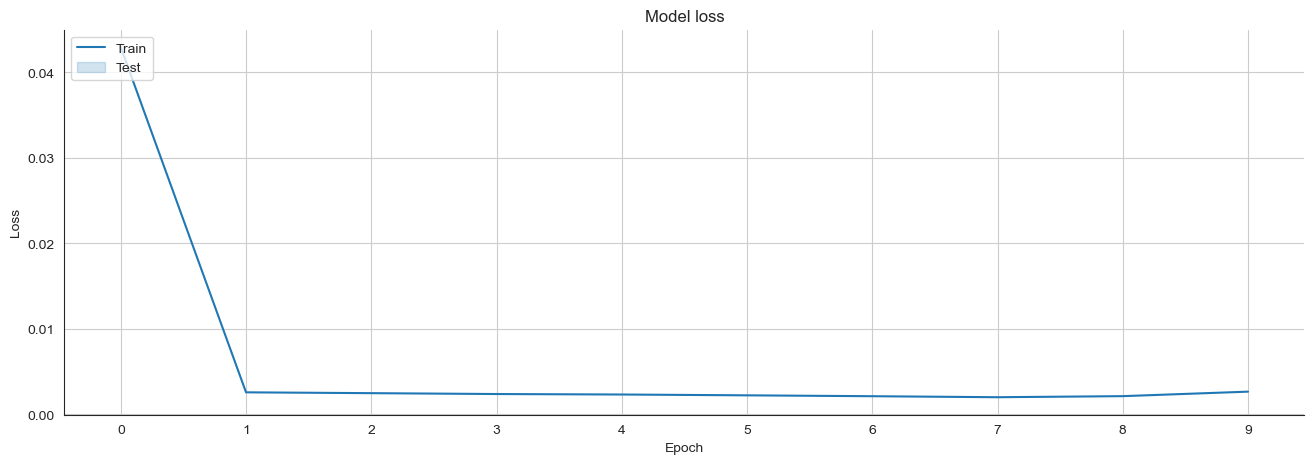

In [13]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

Im weiteren Teil des Codes werden die Vorhersagewerte des Modells ausgewertet. Hier ist eine Beschreibung:

- Mit `y_pred_scaled = model.predict(x_test)` werden die vorhergesagten Werte mit dem trainierten Modell berechnet.

- Die vorhergesagten Werte werden mit `scaler_pred.inverse_transform(y_pred_scaled)` auf den ursprünglichen Wertebereich zurückgesetzt. Dabei wird der Skalierungsprozess umgekehrt.

- Die ursprünglichen Werte der Testdaten werden ebenfalls mit `scaler_pred.inverse_transform(y_test.reshape(-1, 1))` auf den ursprünglichen Wertebereich zurückgesetzt.

- Der mittlere absolute Fehler (MAE) wird mit `mean_absolute_error(y_test_unscaled, y_pred)` berechnet.

- Der mittlere absolute prozentuale Fehler (MAPE) wird mit der Formel `(np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100` berechnet. Dieser Wert gibt den durchschnittlichen prozentualen Unterschied zwischen den Vorhersagen und den tatsächlichen Werten an.

- Der mediane absolute prozentuale Fehler (MDAPE) wird mit der Formel `np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100` berechnet. Dieser Wert gibt den mittleren prozentualen Unterschied zwischen den Vorhersagen und den tatsächlichen Werten an.

- Die berechneten Werte für MAE, MAPE und MDAPE werden ausgegeben.

Der Code berechnet verschiedene Fehlermetriken, um die Genauigkeit der Vorhersagen des Modells zu bewerten. MAE gibt den durchschnittlichen absoluten Unterschied zwischen den Vorhersagen und den tatsächlichen Werten an, während MAPE und MDAPE den durchschnittlichen prozentualen Unterschied angeben. Diese Metriken geben Aufschluss über die Leistung des Modells und ermöglichen eine Bewertung der Vorhersagegenauigkeit.

In [14]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

5/5 [==============================] - 1s 24ms/step


Im weiteren Teil des Codes werden Vorhersagen für den nächsten Tag gemacht und ausgegeben. Hier ist eine Beschreibung:

- `df_temp` wird erstellt, indem die letzten `sequence_length` Zeilen des DataFrame `df` ausgewählt werden.

- `new_df` wird erstellt, indem nur die ausgewählten Features (`FEATURES`) aus `df_temp` behalten werden.

- `last_N_days` wird erstellt, indem die letzten `sequence_length` Tage der Spalte "Close" aus `new_df` extrahiert werden. Diese Werte werden auf den Wertebereich zwischen 0 und 1 skaliert.

- Eine leere Liste `X_test_new` wird erstellt und `last_N_days_scaled` wird als erstes Element hinzugefügt.

- `X_test_new` wird in ein numpy-Array umgewandelt und die Daten werden neu geformt.

- Mit `model.predict(np.array(X_test_new))` werden vorhergesagte Werte für den nächsten Tag berechnet. Diese Werte sind skaliert.

- Die vorhergesagten Werte werden mit `scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))` auf den ursprünglichen Wertebereich zurückgesetzt.

- Der letzte Schlusskurs (`price_today`) und der vorhergesagte Schlusskurs für den nächsten Tag (`predicted_price`) werden ausgegeben.

- Die prozentuale Änderung zwischen dem heutigen Schlusskurs und dem vorhergesagten Schlusskurs für den nächsten Tag wird berechnet und als `change_percent` ausgegeben.

- Die Schlusskurse und die Vorhersagen für den nächsten Tag werden ausgegeben, zusammen mit der prozentualen Änderung.

Der Code erstellt Vorhersagen für den nächsten Tag basierend auf dem trainierten Modell und gibt die Vorhersagen sowie den prozentualen Unterschied zwischen dem heutigen Schlusskurs und der Vorhersage aus. Dies ermöglicht eine Einschätzung der Modellgenauigkeit und kann bei der Entscheidungsfindung unterstützen.

In [15]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

1/1 [==============================] - 0s 30ms/step


Im weiteren Teil des Codes werden Vorhersagen für eine bestimmte Anzahl von nächsten Tagen gemacht und zum DataFrame hinzugefügt. Hier ist eine Beschreibung:

- Die Variable `num_days` gibt an, wie viele Tage vorhergesagt werden sollen.

- In einer Schleife wird für jeden Tag eine Vorhersage getroffen und zum DataFrame hinzugefügt.

- Innerhalb der Schleife werden die aktuellen letzten N Tage (`last_N_days`) aus `new_df` abgerufen und skaliert.

- Eine leere Liste `X_test_new` wird erstellt und `last_N_days_scaled` wird als erstes Element hinzugefügt.

- `X_test_new` wird in ein Numpy-Array umgewandelt und die Daten werden neu geformt.

- Mit `model.predict(np.array(X_test_new))` werden vorhergesagte Werte für den nächsten Tag berechnet. Diese Werte sind skaliert.

- Die vorhergesagten Werte werden auf den ursprünglichen Wertebereich zurückgesetzt und als `predicted_price` gespeichert.

- Das Datum für den nächsten Tag (`next_day`) wird berechnet, indem das letzte Datum aus `new_df` genommen und um einen Tag erhöht wird.

- Die Vorhersage (`predicted_price`) wird dem DataFrame `df` unter dem entsprechenden Datum in der Spalte "Predicted Price" hinzugefügt.

- Der neue Tag (`next_day`) wird `new_df` hinzugefügt.

- Der aktuelle Tag wird aus `new_df` entfernt, um Platz für den nächsten Tag zu machen.

Der Code erstellt Vorhersagen für eine bestimmte Anzahl von nächsten Tagen und fügt sie dem DataFrame hinzu. Dies ermöglicht die Erstellung eines Vorhersageverlaufs für die angegebenen Anzahl von Tagen.

In [16]:
# Anzahl der nächsten Tage, die vorhergesagt werden sollen
num_days = 30

# Vorhersage für jeden Tag treffen und zum DataFrame hinzufügen
for _ in range(num_days):
    # Aktuelle letzten N Tage abrufen und skalieren
    last_N_days = new_df[-sequence_length:].values
    last_N_days_scaled = scaler.transform(last_N_days)
    
    # Leere Liste erstellen und vergangene N Tage hinzufügen
    X_test_new = []
    X_test_new.append(last_N_days_scaled)
    
    # X_test in ein Numpy-Array umwandeln und Daten umformen
    pred_price_scaled = model.predict(np.array(X_test_new))
    pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
    
    # Vorhersage der nächsten 30 Tage speichern
    predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
    
    # Datum für den nächsten Tag berechnen
    next_day = new_df.index[-1] + pd.DateOffset(days=1)
    
    # Vorhersage zum DataFrame hinzufügen
    df.loc[next_day, 'Predicted Price'] = predicted_price
    
    # Neuen Tag zum new_df DataFrame hinzufügen
    new_df.loc[next_day] = predicted_price
    
    # Aktuellen Tag aus dem DataFrame entfernen
    new_df = new_df[1:]

1/1 [==============================] - 0s 22ms/step


Im weiteren Teil des Codes wird der Verlauf der Spalte "Close" visualisiert. Hier ist eine Beschreibung:

- Mit `new_df["Close"].plot()` wird der Verlauf der Spalte "Close" aus dem DataFrame `new_df` geplottet.

- Mit `plt.xlabel()`, `plt.ylabel()` und `plt.title()` werden die Achsenbeschriftungen und der Titel des Diagramms festgelegt.

- Schließlich wird das Diagramm mit `plt.show()` angezeigt.

Der Code erstellt ein Linienplot-Diagramm, das den Verlauf der Spalte "Close" über die Zeit zeigt. Dies ermöglicht eine visuelle Darstellung der Entwicklung der Schlusskurse.

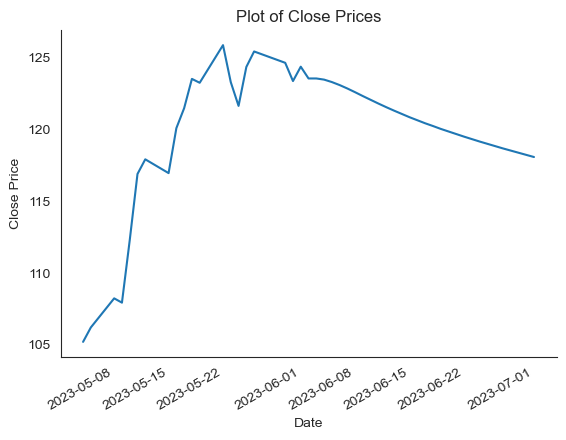

In [17]:
import matplotlib.pyplot as plt

# Plotting the "Close" column
new_df["Close"].plot()

# Adding labels and title
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Plot of Close Prices")

# Displaying the plot
plt.show()


Im weiteren Teil des Codes werden einige Werte im DataFrame `new_df` auf NaN gesetzt und neue Spalten hinzugefügt. Hier ist eine Beschreibung:

- Mit `new_df.loc[start_date_from:, ["Open", "High", "Low", "Volume"]] = np.nan` werden die Werte in den Spalten "Open", "High", "Low" und "Volume" ab dem `start_date_from` auf NaN gesetzt.

- Eine neue Spalte "Date" wird erstellt, die den Index von `new_df` enthält.

- Eine neue Spalte "Company" wird erstellt und mit dem Wert `company_name` befüllt.

- Eine neue Spalte "Type" wird erstellt, indem die Werte in der Spalte "High" überprüft werden. Wenn ein Wert NaN ist, wird der Wert "LSTM_company_name" gesetzt, sonst "Act_company_name".

- In der Spalte "Forecast_Date" werden die Werte in der Spalte "Type" überprüft. Wenn der Wert "LSTM" enthält, wird das Datum `end_date` als Vorhersagedatum eingetragen.

- Eine neue Spalte "Key" wird erstellt, die aus der Kombination von "Company", "Date" und "Type" besteht.

- Die Zeilen im DataFrame `new_df`, in denen die Spalte "Type" den Wert "Act_" enthält, werden entfernt.

Der Code setzt bestimmte Werte auf NaN, fügt neue Spalten hinzu und bereitet den DataFrame `new_df` für die Darstellung der Vorhersagedaten vor. Diese Änderungen ermöglichen es, die Vorhersagedaten mit den tatsächlichen Daten zu vergleichen und zu visualisieren.

In [18]:
# Set values to NaN
start_date_from = end_date
new_df.loc[start_date_from:, ["Open", "High", "Low", "Volume"]] = np.nan
new_df['Date'] = new_df.index
# Key einbinden
#company = data.loc[0]['Company']
new_df['Company'] = company_name
new_df['Type'] = new_df['High'].apply(lambda x: f'LSTM_{company_name}' if np.isnan(x) else f'Act_{company_name}')
new_df.loc[new_df['Type'].str.contains('LSTM'), 'Forecast_Date'] = end_date
new_df['Key'] = new_df['Company'] + '_' + new_df['Date'].astype(str) + '_' + new_df['Type']
new_df = new_df[~new_df["Type"].str.contains("Act_")]

Im weiteren Teil des Codes wird eine Verbindung zur Datenbank hergestellt und Daten aus einer Tabelle abgerufen. Hier ist eine Beschreibung:

- Es wird eine Verbindung zur Datenbank hergestellt, indem der Verbindungsstring `conn_str` verwendet wird.

- Ein SQLAlchemy-Objekt `engine` wird erstellt, das die Verbindung zur Datenbank repräsentiert.

- Es wird eine SQL-Abfrage (`query`) erstellt, um alle Daten aus der Tabelle `stock_data_forecast` abzurufen, bei denen der Wert in der Spalte "TYPE" mit 'LSTM_' beginnt.

- Die SQL-Abfrage wird mit `pd.read_sql(query, cnxn)` ausgeführt und die Ergebnisse werden in einen DataFrame `exists_df` geladen.

- Der DataFrame `exists_df` wird mit `exists_df.astype(data_extended_key.dtypes)` und `exists_df.reindex(columns=data_extended_key.columns)` auf den gleichen Datentyp und die gleiche Spaltenreihenfolge wie der DataFrame `data_extended_key` gebracht.

- Eine neue Spalte "Key" wird erstellt, indem die Werte in den Spalten "Company", "Date" und "Type" kombiniert werden.

Der Code stellt eine Verbindung zur Datenbank her und lädt Daten aus einer Tabelle in einen DataFrame. Dabei werden die Daten an den vorhandenen DataFrame `data_extended_key` angepasst und eine neue Spalte "Key" erstellt, um die Vorhersagedaten eindeutig zu identifizieren.

In [19]:
import pyodbc
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import warnings

# Deaktivieren der Pandas-Warnungen
warnings.filterwarnings('ignore', category=UserWarning)

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Query erstellen, um alle Daten auszulesen
query = "SELECT * FROM stock_data_forecast WHERE [TYPE] LIKE 'LSTM_%'"

# Ausführen der Query und Laden der Ergebnisse in einen DataFrame
exists_df = pd.read_sql(query, cnxn)

# added
exists_df = exists_df.astype(new_df.dtypes)
exists_df = exists_df.reindex(columns=new_df.columns)

# Key einbinden
exists_df['Key'] = exists_df['Company'] + '_' + exists_df['Date'].astype(str) + '_' + exists_df['Type']

Im weiteren Teil des Codes werden die Vorhersagedaten mit den vorhandenen Daten zusammengeführt und in die SQL Server-Tabelle geschrieben. Hier ist eine Beschreibung:

- Der DataFrame `exists_df` wird mit `exists_df.astype(new_df.dtypes)` und `exists_df.reindex(columns=new_df.columns)` auf den gleichen Datentyp und die gleiche Spaltenreihenfolge wie der DataFrame `new_df` gebracht.

- Die beiden DataFrames `new_df` und `exists_df` werden mit `pd.concat([new_df, exists_df])` zusammengeführt und in `combined_df` gespeichert.

- Duplikate in `combined_df` werden mit `combined_df.drop_duplicates(subset=['Key'], keep=False)` entfernt.

- Der aktualisierte DataFrame `combined_df` wird mit `combined_df.to_sql('stock_data_forecast', con=engine, if_exists='append', index=False)` in die SQL Server-Tabelle 'stock_data_forecast' geschrieben.

- Die Anzahl der geschriebenen Zeilen (`num_written_rows`) wird ermittelt und ausgegeben.

- Mit `exists_df = pd.read_sql('SELECT * FROM stock_data_forecast', cnxn)` werden die Daten aus der Tabelle 'stock_data_forecast' erneut in `exists_df` geladen.

- Duplikate in `exists_df` werden mit `exists_df.drop_duplicates(subset='Key', inplace=True)` entfernt.

- Die Verbindung zur Datenbank wird mit `cnxn.close()` geschlossen.

- Eine Bestätigungsmeldung wird ausgegeben, dass die Verbindung erfolgreich geschlossen wurde.

Der Code führt das Zusammenführen der Vorhersagedaten mit den vorhandenen Daten durch und schreibt den aktualisierten DataFrame in die SQL Server-Tabelle. Dabei werden Duplikate entfernt und die Anzahl der geschriebenen Zeilen wird angezeigt. Schließlich wird die Verbindung zur Datenbank geschlossen.

In [20]:
# added
exists_df = exists_df.astype(new_df.dtypes)
exists_df = exists_df.reindex(columns=new_df.columns)

# Zusammenführen der beiden DataFrames
combined_df = pd.concat([new_df, exists_df])

# Entfernen von Duplikaten
combined_df = combined_df.drop_duplicates(subset=['Key'], keep=False)

# Schreiben des aktualisierten DataFrames in die SQL Server-Tabelle
combined_df.to_sql('stock_data_forecast', con=engine, if_exists='append', index=False)

# Anzahl der geschriebenen Zeilen erhalten
num_written_rows = combined_df.shape[0]
print(f"Es wurden {num_written_rows} Zeilen erfolgreich übertragen.")

exists_df = pd.read_sql('SELECT * FROM stock_data_forecast', cnxn)
exists_df.drop_duplicates(subset='Key', inplace=True)

# Verbindung schließen
cnxn.close()
print(f"Die Verbindung ist wieder geschlossen.")

Es wurden 59 Zeilen erfolgreich übertragen.
Die Verbindung ist wieder geschlossen.


In [21]:
combined_df

,High,Low,Open,Close,Volume,Date,Company,Type,Forecast_Date,Key
2023-06-01 00:00:00,NaN,NaN,NaN,124.370003,NaN,2023-06-01,GOOG,LSTM_GOOG,2023-06-01,GOOG_2023-06-01_LSTM_GOOG
2023-06-02 00:00:00,NaN,NaN,NaN,123.550003,NaN,2023-06-02,GOOG,LSTM_GOOG,2023-06-01,GOOG_2023-06-02_LSTM_GOOG
2023-06-03 00:00:00,NaN,NaN,NaN,123.550003,NaN,2023-06-03,GOOG,LSTM_GOOG,2023-06-01,GOOG_2023-06-03_LSTM_GOOG
2023-06-04 00:00:00,NaN,NaN,NaN,123.470001,NaN,2023-06-04,GOOG,LSTM_GOOG,2023-06-01,GOOG_2023-06-04_LSTM_GOOG
2023-06-05 00:00:00,NaN,NaN,NaN,123.300003,NaN,2023-06-05,GOOG,LSTM_GOOG,2023-06-01,GOOG_2023-06-05_LSTM_GOOG
2023-06-06 00:00:00,NaN,NaN,NaN,123.089996,NaN,2023-06-06,GOOG,LSTM_GOOG,2023-06-01,GOOG_2023-06-06_LSTM_GOOG
2023-06-07 00:00:00,NaN,NaN,NaN,122.849998,NaN,2023-06-07,GOOG,LSTM_GOOG,2023-06-01,GOOG_2023-06-07_LSTM_GOOG
2023-06-08 00:00:00,NaN,NaN,NaN,122.589996,NaN,2023-06-08,GOOG,LSTM_GOOG,2023-06-01,GOOG_2023-06-08_LSTM_GOOG
2023-06-09 00:00:00,NaN,NaN,NaN,122.320000,NaN,2023-06-09,GOOG,LSTM_GOOG,2023-06-01,GOOG_2023-06-09_LSTM_GOOG
2023-06-10 00:00:00,NaN,NaN,NaN,122.059998,NaN,2023-06-10,GOOG,LSTM_GOOG,2023-06-01,GOOG_2023-06-10_LSTM_GOOG
